## Simple MTBD with moment-mediated mean-field interaction

In [1]:
import jax
import jax.numpy as jnp
import jaxopt
import diffrax as dx
import equinox as eqx
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

In [2]:
seed = 0
keys = jax.random.split(jax.random.PRNGKey(seed), 3)

In [3]:
d = 10

λ = jnp.exp(jax.random.normal(keys[0], (d,)))

μ = jnp.exp(jax.random.normal(keys[1], (d,)))

Γ = jnp.exp(jax.random.normal(keys[2], (d, d)))
Γ = Γ.at[jnp.arange(d), jnp.arange(d)].set(0)
Γ = Γ.at[jnp.arange(d), jnp.arange(d)].set(-Γ.sum(1))

W = jnp.ones((d, d))

In [4]:
τ = 10.0

v0 = jnp.zeros(d)
v0 = v0.at[0].set(1.0)

In [5]:
@jax.jit
def f(t, v, φ):
    return (jnp.diag(λ * jnp.exp(-W @ φ.evaluate(t)) - μ) + Γ) @ v

In [6]:
solver = dx.Dopri8()
dt0 = 0.01 * τ
saveat = dx.SaveAt(dense=True)

In [7]:
@jax.jit
def 𝒯(φ):
    return dx.diffeqsolve(dx.ODETerm(f), solver, 0.0, τ, dt0, v0, args=φ, saveat=saveat)

In [8]:
class ConstantInterp(eqx.Module):
    value: jax.Array
    def evaluate(self, t):
        return self.value

error: nan


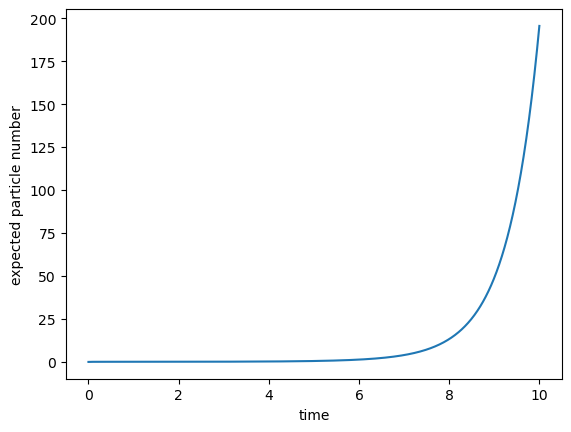

FixedPointState(iter_num=Array(1, dtype=int64, weak_type=True), error=Array(nan, dtype=float64), aux=None)

In [9]:
fixed_point_solver = jaxopt.FixedPointIteration(𝒯, maxiter=1000, tol=1e-05, verbose=True)

φ = 𝒯(ConstantInterp(v0))  # need to do one iteration to get the right pytree structure
φ, state = fixed_point_solver.run(φ)

time_grid = jnp.linspace(0.0, τ, 1000)
plt.plot(time_grid, jax.vmap(φ.evaluate)(time_grid).T[2])
plt.xlabel("time")
plt.ylabel("expected particle number")
# plt.yscale("log")
plt.show()

state